# <center> SVI </center>

Raw parametrization:

$$ w(k, X_R) = a + b\{\rho(k - m) + \sqrt{(k - m)^2 + \sigma^2} \}$$

Jump-Wing parametrization:

$$ v_t = \frac{a + b\{-\rho m + \sqrt{m^2 + \sigma^2} \}}{T} $$

$$ \psi_t = \frac{b}{2\sqrt{v_t T}} (-\frac{m}{\sqrt{m^2 + \sigma^2}} + \rho)$$

$$ p_t = \frac{b(1 - \rho)}{\sqrt{v_t T}} $$

$$ c_t = \frac{b(1 + \rho)}{\sqrt{v_t T}} $$

$$ \tilde{v_t} = \frac{a + b\sigma \sqrt{1 - \rho^2})}{T} $$

# <center>(DEPRECATED, need to go via blips) </center>

Define:

$$ \beta = \rho - \frac{2 \psi_t \sqrt{v_t T}}{b} $$
$$ \alpha = sign{\beta} \sqrt{\frac{1}{\beta^2} -1}$$

So:

$$ b = \frac{\sqrt{v_t T} (c_t + p_t)}{2} $$

$$ \rho = 1 - \frac{p_t\sqrt{v_t T}}{b} $$

$$ a = \tilde{v_t} T  - b \sigma \sqrt{1 - \rho^2} $$

$$ m = \frac{(v_t-\tilde{v_t})T}{b(-\rho + sign(\alpha)\sqrt{1+\alpha^2}-\alpha\sqrt{1-\rho^2})} $$

$$ \sigma = \begin{cases}
      \frac{(\tilde{v_t}   - v_t) T }{b(\sqrt{1 - \rho^2} - 1)} , m = 0 \\
      m \alpha , other
    \end{cases} $$
    




So compute greeks by JW params as: 

$$\Delta = \frac{d C}{d f} = \frac{d C}{d \sigma} \frac{d \sigma}{d f} = \frac{d C}{d \sigma} \frac{d \sigma}{d w} \frac{d w}{d f} = Vega_{BSM} \frac{d \sigma}{d w} \frac{d w}{d f} $$

$$\Gamma = \frac{d^ 2C}{d f ^2} = \frac{d \Delta}{d f}  = Vanna_{BSM}\frac{d \sigma}{d w} \frac{d w}{d f} + Vega_{BSM}  \frac{d}{d f} (\frac{d \sigma}{d w} \frac{d w}{d f}) $$


$$ \frac{d C}{d v_t} = \frac{d C}{d \sigma} \frac{d \sigma}{d v_t} = \frac{d C}{d \sigma} \frac{d \sigma}{d a} \frac{d a}{d v_t}  = Vega_{BSM} \frac{d \sigma}{d a} \frac{d a}{d v_t} $$

$$ \frac{d C}{d \psi_t} = \frac{d C}{d \sigma} \frac{d \sigma}{d \psi_t} = \frac{d C}{d \sigma} \frac{d \sigma}{d a} \frac{d a}{d \psi_t}  = Vega_{BSM} \frac{d \sigma}{d a} \frac{d a}{d \psi_t} $$

$$ \frac{d C}{d p_t} = \frac{d C}{d \sigma} \frac{d \sigma}{d p_t} = \frac{d C}{d \sigma} \frac{d \sigma}{d a} \frac{d a}{d p_t}  = Vega_{BSM} \frac{d \sigma}{d a} \frac{d a}{d p_t} $$

$$ \frac{d C}{d c_t} = \frac{d C}{d \sigma} \frac{d \sigma}{d c_t} = \frac{d C}{d \sigma} \frac{d \sigma}{d a} \frac{d a}{d c_t}  = Vega_{BSM} \frac{d \sigma}{d a} \frac{d a}{d c_t} $$

$$ \frac{d C}{d \tilde{v_t}} = \frac{d C}{d \sigma} \frac{d \sigma}{d \tilde{v_t}} = \frac{d C}{d \sigma} \frac{d \sigma}{d a} \frac{d a}{d \tilde{v_t}}  = Vega_{BSM} \frac{d \sigma}{d a} \frac{d a}{d \tilde{v_t}} $$

$$ \frac{d C}{d \sigma} \frac{d \sigma}{d b} \frac{d b}{d \psi_t} =  \frac{d b}{d \psi_t} = 0(\text{can not be zero by all nodes}) \neq \frac{d C}{d \sigma} \frac{d \sigma}{d a} \frac{d a}{d \psi_t} $$

$$ \frac{d C}{d \psi_t} = \frac{d C}{d \sigma} \frac{d \sigma}{d \psi_t} = \frac{d C}{d \sigma} \frac{d \sigma}{d b} \frac{d b}{d \psi_t} = \frac{d C}{d \sigma} \frac{d \sigma}{d b} \frac{d(\frac{\sqrt{v_t T} (c_t + p_t))}{2}}{d \psi_t} = 0$$

### <center> JW sympy </center>

In [1]:
import sympy as sym
import sympy.printing as printing

In [2]:
# Jump wing parametrization
sym.init_printing()
v_t, psi_t, p_t, c_t, v_tilde, f, K, T = sym.symbols('v_t psi_t p_t c_t vtilde_t f K T')
k = sym.log(K/f)
b = sym.sqrt(T*v_t)*(c_t + p_t)/2
rho = 1 - p_t*sym.sqrt(T*v_t)/b
beta = rho - 2*psi_t*sym.sqrt(T*v_t)/b
alpha = sym.sqrt(1/beta**2 -1)
m = T*(v_t - v_tilde)/(b*(-rho + sym.sign(alpha)*sym.sqrt(1+alpha**2) - alpha*sym.sqrt(1 - rho**2)))
sigma = m*alpha
a = v_tilde*T - b*sigma*sym.sqrt(1 - rho**2)

In [3]:
b

In [4]:
b.diff(v_t)

In [5]:
b.diff(psi_t)

In [6]:
b.diff(p_t)

In [7]:
b

### <center> Greeks by raw params, delta, gamma, by K </center>

In [8]:
# in ordinary parametrization
a, b, rho, m, sigma, f, K, T = sym.symbols('a b rho m sigma f K T')
k = sym.log(K/f)
w = a + b *(rho*(k - m) + sym.sqrt((k-m)**2 + sigma**2)) #total iv
v = sym.sqrt(w/T) # iv

In [9]:
w.subs(k, "k")

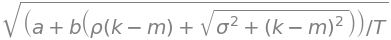

In [10]:
v.subs(k, "k")

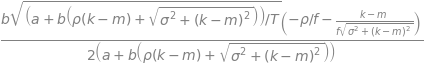

In [11]:
v.diff(f).subs(k, "k")

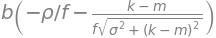

In [12]:
#delta
w.diff(f).subs(k, "k")# sym.sqrt(T*w)

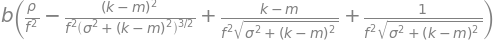

In [13]:
#gamma
w.diff(f).diff(f).subs(k, "k")

In [14]:
# a
w.diff(a).subs(k, "k")

In [15]:
# b
w.diff(b).subs(k, "k")

In [16]:
# rho
w.diff(rho).subs(k, "k")

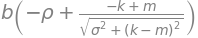

In [17]:
# m
w.diff(m).subs(k, "k")

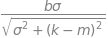

In [18]:
# sigma
w.diff(sigma).subs(k, "k")

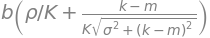

In [19]:
# K
w.diff(K).subs(k, "k")

 ##  <center> Calibration </center> 

In [20]:
from importlib import reload
import pyquant.svi
reload(pyquant.svi)

from pyquant.svi import *
from pyquant.common import *
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd

import itertools
from scipy.stats import norm
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 1000)
%matplotlib inline

In [21]:
bs_calc = BSCalc()

strikes = np.array([1300., 1400, 1500, 1600, 1700, 1800., 1900, 2000, 2100, 2200])
call_strikes = np.array([1800., 1900, 2000, 2100, 2200])
tau = 0.01
F = 1723.75
pvs = np.array([ 1.72375, 1.72375, 3.4475, 6.895, 26.718125, 11.204375,
                4.309375, 1.72375, 0.861875, 0.861875])

implied_vols = bs_calc.implied_vols(
    Forward(Spot(F), ForwardYield(0.), TimeToMaturity(tau)), 
    Strikes(strikes),
    Premiums(pvs)
).data

vol_smile_chain = VolSmileChain(
    Forward(Spot(F), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    ImpliedVols(implied_vols)
)
weights = CalibrationWeights(np.ones_like(vol_smile_chain.Ks))



In [22]:
svi_calc = SVICalc()
calibrated_params = svi_calc.calibrate(vol_smile_chain, weights)
calibrated_params.array()

/Users/zugzvangg/Desktop/Projects/noa/docs/quant/pyquant/svi.py:479: RuntimeWarning: invalid value encountered in sqrt
  denominator = 2 * np.sqrt(T * w)
/Users/zugzvangg/Desktop/Projects/noa/docs/quant/pyquant/svi.py:446: RuntimeWarning: invalid value encountered in sqrt
  iv = np.sqrt(w / T)


array([-0.05516348,  0.19508255, -0.53059706, -0.22331506,  0.35125428])

In [23]:
svi_calc.calibration_error

In [24]:
svi_calc.raw_cached_params

array([-0.05516348,  0.19508255, -0.53059706, -0.22331506,  0.35125428])

In [25]:
svi_calc.jump_wing_cached_params

array([0.292075  , 0.0106822 , 5.52499778, 1.69440429, 0.29187617])

In [26]:
test_strikes = Strikes(np.linspace(strikes[0], strikes[-1], 100))

In [27]:
test_iv = svi_calc.implied_vols(
    Forward(Spot(F), ForwardYield(0.), TimeToMaturity(tau)),
    test_strikes,
    calibrated_params
)

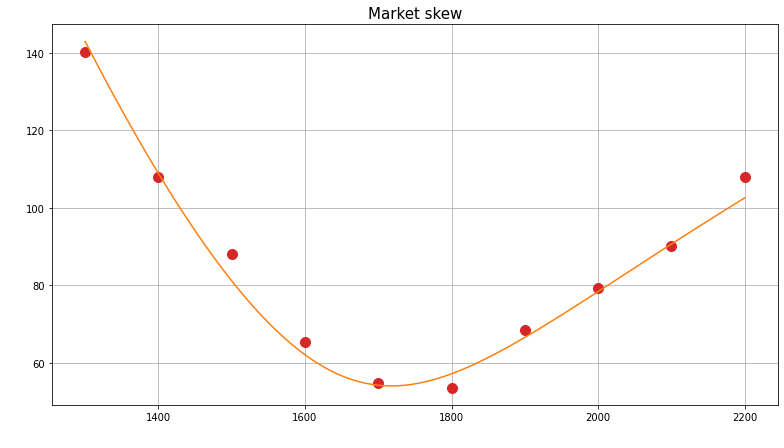

In [28]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.plot(test_strikes.data, 100*test_iv.data, 'C1')
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

### Warm starting

In [29]:
new_forward = 1723.25
new_pvs = np.array([ 0.861625,  1.72325 ,  3.4465  ,  6.893   , 26.710375,
                    11.201125,  4.308125,  1.72325 ,  1.72325 ,  0.861625])

In [30]:
new_implied_vols = bs_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    Premiums(new_pvs)
).data

In [31]:
new_vol_smile_chain = VolSmileChain(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    ImpliedVols(new_implied_vols)
)

In [32]:
svi_calc.cached_params = calibrated_params.array()

In [33]:
new_calibrated_params = svi_calc.calibrate(new_vol_smile_chain,  weights)
print(svi_calc.calibration_error)
new_calibrated_params.array()

6.0128917261860604e-06


array([-0.01094361,  0.08051245, -0.00554534,  0.01066677,  0.172677  ])

### BSM limit

In [34]:
flat_implied_vols = np.ones_like(implied_vols)*0.8
flat_vol_smile_chain = VolSmileChain(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    ImpliedVols(flat_implied_vols)
)
svi_calc.update_raw_cached_params(
    SVIRawParams(A(100.0), B(1.0), Rho(0.0), M(1.0), Sigma(1.0))
)
flat_calibrated_params = svi_calc.calibrate(flat_vol_smile_chain,  weights)
print(svi_calc.calibration_error)
flat_calibrated_params.array()

8.326443965321616e-09


/Users/zugzvangg/Desktop/Projects/noa/docs/quant/pyquant/svi.py:479: RuntimeWarning: invalid value encountered in sqrt
  denominator = 2 * np.sqrt(T * w)
/Users/zugzvangg/Desktop/Projects/noa/docs/quant/pyquant/svi.py:446: RuntimeWarning: invalid value encountered in sqrt
  iv = np.sqrt(w / T)


array([ 6.41282966e-03,  1.00000000e-04, -9.99900000e-01, -2.35533478e+01,
        1.00000000e-04])

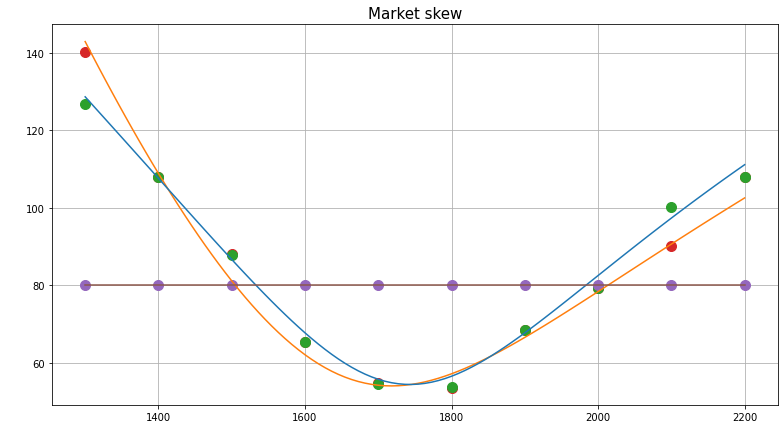

In [35]:
flat_test_iv = svi_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    test_strikes,
    flat_calibrated_params
)
new_test_iv = svi_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    test_strikes,
    new_calibrated_params
)
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.plot(strikes, 100*new_implied_vols, '.C2', markersize=20)
plt.plot(strikes, 100*flat_implied_vols, '.C4', markersize=20)
plt.plot(test_strikes.data, 100*test_iv.data, 'C1')
plt.plot(test_strikes.data, 100*new_test_iv.data, 'C0')
plt.plot(test_strikes.data, 100*flat_test_iv.data, 'C5')
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

### Raw params greeks

In [36]:
from importlib import reload
import pyquant.svi
reload(pyquant.svi)
from pyquant.svi import *

In [41]:
svi_calc = SVICalc()

test_K = 1900
F = 1723.75
tau = 0.01

# by one strike as in pyquant/SABR API

test_delta = svi_calc.delta(
    Forward(Spot(F), ForwardYield(0.), TimeToMaturity(tau)),
    Strike(test_K),
    OptionType(True),
    calibrated_params
)
test_delta.pv

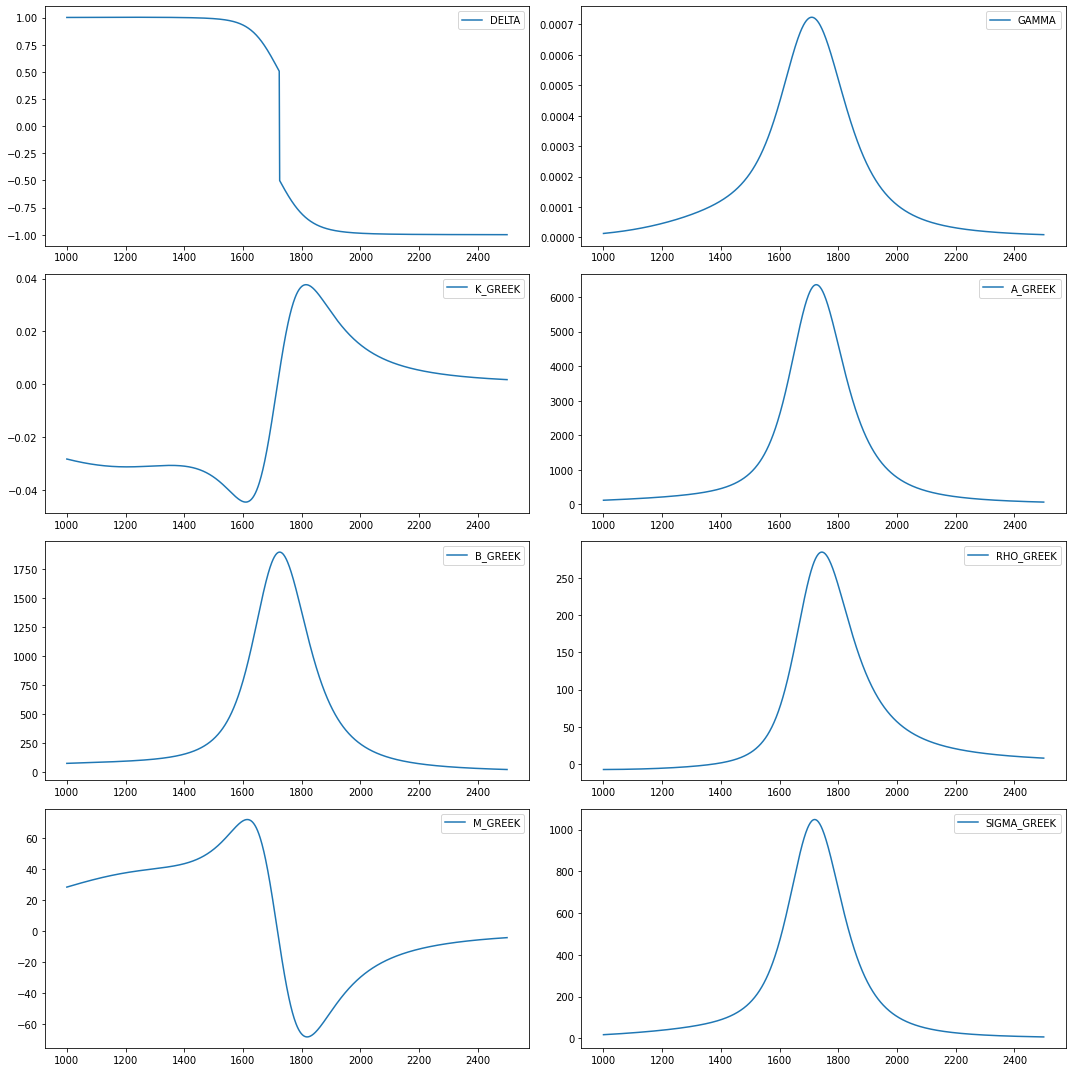

In [38]:
N = 1000
Ks = np.linspace(1000.0, 2500.0, N)
methods_list = ["deltas","gammas", "k_greeks", "a_greeks", "b_greeks", "rho_greeks", "m_greeks", "sigma_greeks"]
raw_greeks = np.zeros((len(methods_list), N))

for i, method_name in enumerate(methods_list):
    if method_name == "deltas":
        values = getattr(svi_calc, method_name)(Forward(Spot(F), ForwardYield(0.), TimeToMaturity(tau)), Strikes(Ks), OptionTypes(F > Ks), calibrated_params)
    else:    
        values = getattr(svi_calc, method_name)(Forward(Spot(F), ForwardYield(0.), TimeToMaturity(tau)), Strikes(Ks), calibrated_params)
    raw_greeks[i, :] = values.data


fig, axs = plt.subplots(4, 2, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    ax.plot(Ks, raw_greeks[i])
    ax.legend([f'{methods_list[i][:-1].upper()}'])

# Отображение графиков
plt.tight_layout()
plt.show()
